# Plane stress example

### Preamble

- Include the necesary modules from Julia's standard repositories.

In [1]:
using LinearAlgebra
using Printf, AbaqusReader, Logging
using PyCall, PyPlot

In [2]:
using AD4SM

A few helper functions

In [3]:
mean(x) = sum(x)/length(x)

# this function is the constraint equation for the internal holes
function cnst_func(u,ucntr,r0,cntr0,Rsq) 
    r    = r0+u
    cntr = cntr0+ucntr
    sum((r-cntr).^2)-Rsq
end
# this function find the centre of the constrained holes in the reference configuration
function find_centre(nodes; dTol = 1e-12, maxiter=21)

  c0    = mean(nodes)
  bdone = false  
  iter  = 0

  while !bdone
    D2c0   = adiff.D2(c0)
    global deltas = [(D2c0[1]-p[1]).^2+(D2c0[2]-p[2]).^2 for p in nodes]
    r      = norm(deltas)
    grad   = adiff.grad(r)
    if (norm(grad)<dTol) || (iter>maxiter)
      bdone = true
    else
      c0  -= adiff.hess(r)\grad
    end
    iter +=1
  end
  Rsquares = adiff.val.(deltas) 
  return (c0, Rsquares)
end
    
# some plotting functions
patch = pyimport("matplotlib.patches")
coll  = pyimport("matplotlib.collections")  

function plot_model(elems, nodes; 
                    u = zeros(length(nodes[1]), length(nodes)),
                    Φ = [],
                    linewidth = 0.25,
                    facecolor = :c,
                    edgecolor = :b, 
                    alpha     = 1,
                    cmap      = :hsv,
                    clim      = [],
                    dTol      = 1e-6,
                    cfig      = figure(),
                    ax        = cfig.add_subplot(1,1,1))

  nodes     = [node + u[:,ii] for (ii,node) in enumerate(nodes)]
  patchcoll = coll.PatchCollection([patch.Polygon(nodes[elem.nodes]) 
                                    for elem ∈ elems], cmap=cmap)
  if !isempty(Φ)
    patchcoll.set_array(Φ)
    cfig.colorbar.(patchcoll, ax=ax)

    if isempty(clim)
      clim = patchcoll.get_clim()
      if abs(clim[2]-clim[1]) < dTol
        clim  = sum(clim)/2*[0.9, 1.1]
      end
    end
    patchcoll.set_clim(clim)
  else
    patchcoll.set_color(facecolor)
  end

  patchcoll.set_edgecolor(edgecolor)
  patchcoll.set_alpha(alpha)
  patchcoll.set_linewidth(linewidth)

  ax.set_aspect("equal")
  ax.add_collection(patchcoll)
  ax.autoscale()
  return (cfig, ax, patchcoll)
end
function get_I1(elems, u0)
      
    nElems = length(elems)
    F      = Elements.getinfo(elems,u0,info=:F)
    J      = [det(F)                       for F  in F]
    C      = [transpose(F)*F               for F  in F]
    L3     = [(C[1]C[4]-C[2]C[3])^-1       for C  in C]
    Ic     = [Materials.getInvariants(C[ii], L3[ii]) for ii in 1:nElems] 

    I1     = [item[1] for item in Ic]
end 
;

A few parameters controlling the simulation, file naming, output produced etc, are set

In [4]:
sMeshFile = "Pattern2D03FinerMesh02j.inp"
ϵn0       = 0.24
bfside    = true
mat       = Materials.NeoHooke(10.0)
bprogress = false
bwarmup   = true
blheqs    = false
bsheqs    = true
sFileName = splitext(sMeshFile)[1]
;

Load the mesh and store node sets

In [5]:
mymodel   = with_logger(Logging.NullLogger()) do
  AbaqusReader.abaqus_read_mesh(sMeshFile)
end
@printf("\n\t loaded %s \n", sMeshFile)

(xmin, xmax) = extrema([item[2][1] for item ∈ mymodel["nodes"]])
(ymin, ymax) = extrema([item[2][2] for item ∈ mymodel["nodes"]])

nodes    = [mymodel["nodes"][ii]    for ii ∈ 1:length(mymodel["nodes"])]
el_nodes = [mymodel["elements"][ii] for ii ∈ 1:length(mymodel["elements"])]
elems    = [Elements.Quad(item, nodes[item], mat=mat) for item ∈ el_nodes]


@show nNodes, nElems  = length(nodes), length(el_nodes)
@show Δx, Δy          = (xmax-xmin), (ymax-ymin)

nid_bndl = mymodel["node_sets"]["ID_L"]
nid_bndr = mymodel["node_sets"]["ID_R"]
nid_bndt = mymodel["node_sets"]["ID_T"]
nid_bndb = mymodel["node_sets"]["ID_B"]

nid_sh01 = mymodel["node_sets"]["ID_SH01"]
nid_sh02 = mymodel["node_sets"]["ID_SH02"]
nid_sh03 = mymodel["node_sets"]["ID_SH03"]
nid_sh04 = mymodel["node_sets"]["ID_SH04"]
nid_sh05 = mymodel["node_sets"]["ID_SH05"]
nid_sh06 = mymodel["node_sets"]["ID_SH06"]
nid_sh07 = mymodel["node_sets"]["ID_SH07"]
nid_sh08 = mymodel["node_sets"]["ID_SH08"]
nid_sh09 = mymodel["node_sets"]["ID_SH09"]

nid_shx  = [nid_sh01, nid_sh02, nid_sh03,
          nid_sh04, nid_sh05, nid_sh06,
          nid_sh07, nid_sh08, nid_sh09]
nSHs     = length(nid_shx)

nid_lh01 = mymodel["node_sets"]["ID_LH01"]
nid_lh02 = mymodel["node_sets"]["ID_LH02"]
nid_lh03 = mymodel["node_sets"]["ID_LH03"]
nid_lh04 = mymodel["node_sets"]["ID_LH04"]
nid_lh05 = mymodel["node_sets"]["ID_LH05"]
nid_lh06 = mymodel["node_sets"]["ID_LH06"]
nid_lh07 = mymodel["node_sets"]["ID_LH07"]
nid_lh08 = mymodel["node_sets"]["ID_LH08"]
nid_lh09 = mymodel["node_sets"]["ID_LH09"]
nid_lh10 = mymodel["node_sets"]["ID_LH10"]
nid_lh11 = mymodel["node_sets"]["ID_LH11"]
nid_lh12 = mymodel["node_sets"]["ID_LH12"]
nid_lh13 = mymodel["node_sets"]["ID_LH13"]
nid_lh14 = mymodel["node_sets"]["ID_LH14"]
nid_lh15 = mymodel["node_sets"]["ID_LH15"]
nid_lh16 = mymodel["node_sets"]["ID_LH16"]

nid_lhx  = [nid_lh01, nid_lh02, nid_lh03,
          nid_lh04, nid_lh05, nid_lh06,
          nid_lh07, nid_lh08, nid_lh09, nid_lh10,
          nid_lh11, nid_lh12, nid_lh13,
          nid_lh14, nid_lh15, nid_lh16]
nLHs     = length(nid_lhx)

cntrs_s = [find_centre(nodes[idx]) for idx in nid_shx]
cntrs_l = [find_centre(nodes[idx]) for idx in nid_lhx]
nodes = vcat(nodes,getindex.(cntrs_s,1),getindex.(cntrs_l,1))
;


	 loaded Pattern2D03FinerMesh02j.inp 
(nNodes, nElems) = (length(nodes), length(el_nodes)) = (11678, 10832)
(Δx, Δy) = (xmax - xmin, ymax - ymin) = (20.0, 20.0)


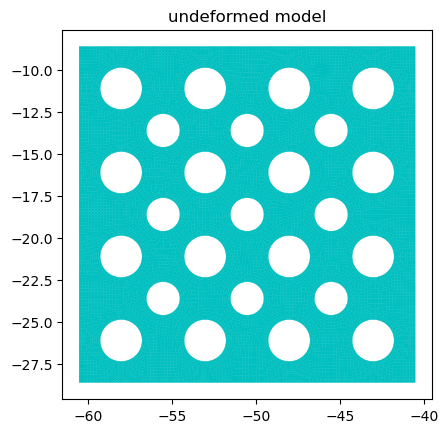

In [6]:
plot_model(elems, nodes, facecolor=:c, edgecolor=:c)
PyPlot.title("undeformed model")
;

Write constraint equations for the holes:
 - if bsheqs is true equations are added for the smaller holes
 - if blheqs is true equations are added for the larger holes

In [7]:
idxs  = LinearIndices(((2, nNodes+nSHs+nLHs)))
eqns  = Array{Solvers.ConstEq}(undef, 0)
if bsheqs
    eqns  = vcat(eqns,
                 [ [ begin
                      r0      = nodes[nid]
                      cntr0   = nodes[nNodes+ii]
                      Rsq     = cntrs_s[ii][2][jj]
                      id_dofs = vcat(idxs[:,nid][:],idxs[:,nNodes+ii][:])
                      Solvers.ConstEq(x->cnst_func(x[1:2],x[3:4],r0,cntr0,Rsq), 
                                       id_dofs,adiff.D2) 
                    end  for (jj,nid) in enumerate(nid_ii)] 
                  for (ii,nid_ii) in enumerate(nid_shx)]...)
end
if blheqs
    eqns = vcat(eqns,
                [ [ begin
                     r0      = nodes[nid]
                     cntr0   = nodes[nNodes+nSHs+ii]
                     Rsq     = cntrs_l[ii][2][jj]
                     id_dofs = vcat(idxs[:,nid][:],idxs[:,nNodes+nSHs+ii][:])
                     Solvers.ConstEq(x->cnst_func(x[1:2],x[3:4],r0,cntr0,Rsq), 
                                      id_dofs,adiff.D2) 
                   end  for (jj,nid) in enumerate(nid_ii)] 
                 for (ii,nid_ii) in enumerate(nid_lhx)]... )
end
;

prepare a few arrays needed to start the solution
- u is the displacement vector, it contains the boundary conditions,
- ifree is an array of boolean with the same dimension of u, if ifree is true that DoFs is free, otherwise it is constrained, and the value of the constraint is stored in u

### Do the compressive branch

- initialize the displacement vector and the boundary conditions: u is the array with the DoFs, the NaN entries in u are free DoFs, the !NaN entries are the boundary conditions

In [8]:
u                  = fill(NaN, 2, nNodes+nSHs+nLHs)
u[:,nid_bndb]     .= 0
u[1,nid_bndt]     .= 0 
u[2,nid_bndt]     .= -ϵn0*Δy

if !bsheqs u[:,nNodes+1:nNodes+nSHs] .= NaN; end
if !blheqs u[:,nNodes+nSHs+1:end]    .= NaN; end

if !bfside
    u[1,nid_bndl] .= 0 
    u[1,nid_bndr] .= 0 
end

ifree     = isnan.(u)
icnst     = .!ifree
;

- this is a preliminary step, for making sure all constranints are initially satisfied and avoid non-convergence on the first step, the result is used as initial condition for the simulation

In [9]:
u0         = 1e-4Δx*randn(2, nNodes+nSHs+nLHs)
u0[icnst] .= 0
unew       = copy(u0)
@time Solvers.solvestep!(elems, u0, unew, ifree, eqns=eqns, λ = zeros(length(eqns)), becho=true)
u[ifree] .= unew[ifree]
;


predictor step done in 7.93 sec., with normupdt: 9.75e-03, starting corrector loop
iter:  0, norm0: 8.32e-03, normru: 4.99e-01, normre: 3.44e-02, normupdt: 2.85e-02, α: -0.908, eltime: 0.54 sec.
iter:  1, norm0: 4.46e-04, normru: 4.54e-01, normre: 5.50e-04, normupdt: 1.60e-02, α: -0.814, eltime: 0.48 sec.
iter:  2, norm0: 1.88e-06, normru: 2.46e-06, normre: 8.50e-06, eltime: 0.34 sec.
 13.964125 seconds (39.58 M allocations: 4.789 GiB, 6.36% gc time, 85.82% compilation time)


### Do the compressive branch

In [10]:
N       = 24
LF_c    = vcat(range(0.0, 0.9, length=2N÷8),
               range(0.9, 1.0, length=6N÷8))

allus_c = Solvers.solve(elems, u, LF=LF_c, ifree=ifree, eqns=eqns, becho=true, bechoi=true)
;


predictor step done in 0.53 sec., with normupdt: 0.00e+00, starting corrector loop
iter:  0, norm0: 0.00e+00, normru: 0.00e+00, normre: 0.00e+00, eltime: 0.42 sec.
step   1/24, LF=0.000, done in  1 iter, after 0.94 sec.

predictor step done in 0.48 sec., with normupdt: 8.65e-01, starting corrector loop
iter:  0, norm0: 1.17e-02, normru: 7.45e-02, normre: 1.36e-03, normupdt: 1.08e-02, α:  0.093, eltime: 0.56 sec.
iter:  1, norm0: 1.17e-02, normru: 1.05e-04, normre: 6.90e-06, normupdt: 2.64e-04, α:  0.536, eltime: 0.58 sec.
iter:  2, norm0: 1.17e-02, normru: 5.44e-08, normre: 1.03e-07, eltime: 0.48 sec.
step   2/24, LF=0.180, done in  3 iter, after 2.10 sec.

predictor step done in 0.54 sec., with normupdt: 8.67e-01, starting corrector loop
iter:  0, norm0: 2.48e-02, normru: 4.08e-02, normre: 1.78e-03, normupdt: 1.36e-02, α:  0.107, eltime: 0.60 sec.
iter:  1, norm0: 2.49e-02, normru: 7.28e-05, normre: 1.07e-05, normupdt: 4.01e-04, α:  0.506, eltime: 0.74 sec.
iter:  2, norm0: 2.49e-02,

In [11]:
rf_tot_c = [sum(item[2][2,nid_bndt])   for item in allus_c]
Δu_tot_c = [mean(item[1][2,nid_bndt])  for item in allus_c]
;

- plot the results

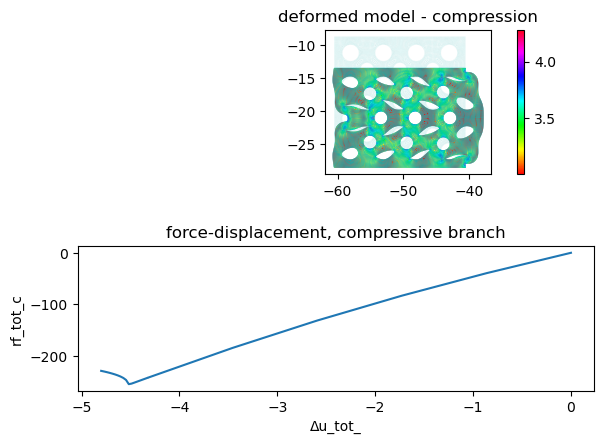

In [12]:
I1 = get_I1(elems, allus_c[end][1])

cfig = figure()
ax1   = cfig.add_subplot(2,1,1)

plot_model(elems, nodes, alpha=0.05, 
  facecolor=:c, edgecolor=:c, cfig=cfig, ax=ax1)
plot_model(elems, nodes, u = allus_c[end][1], 
  edgecolor=:c, Φ = get_I1(elems, allus_c[end][1]), cfig=cfig, ax=ax1)
title("deformed model - compression")

ax2   = cfig.add_subplot(2,1,2)
ax2.plot(Δu_tot_c, rf_tot_c)
xlabel("Δu_tot_")
ylabel("rf_tot_c")
title("force-displacement, compressive branch")

cfig.tight_layout(pad=2.0, w_pad=2.0, h_pad=2.0)
;

### Do the tensile branch

In [13]:
u                  = fill(NaN, 2, nNodes+nSHs+nLHs)
u[:,nid_bndb]     .= 0
u[1,nid_bndt]     .= 0 
u[2,nid_bndt]     .= ϵn0*Δy

if !bsheqs u[:,nNodes+1:nNodes+nSHs] .= NaN; end
if !blheqs u[:,nNodes+nSHs+1:end]    .= NaN; end

if !bfside
    u[1,nid_bndl]     .= 0 
    u[1,nid_bndr]     .= 0 
end

ifree     = isnan.(u)
icnst     = .!ifree
;

In [14]:
u0         = 1e-4Δx*randn(2, nNodes+nSHs+nLHs)
u0[icnst] .= 0
unew       = copy(u0)
@time Solvers.solvestep!(elems, u0, unew, ifree, eqns=eqns, λ = zeros(length(eqns)), becho=true)
u[ifree] .= unew[ifree]
;


predictor step done in 0.56 sec., with normupdt: 9.78e-03, starting corrector loop
iter:  0, norm0: 8.84e-03, normru: 4.71e-01, normre: 3.99e-02, normupdt: 2.98e-02, α: -0.908, eltime: 0.83 sec.
iter:  1, norm0: 5.15e-04, normru: 3.98e-01, normre: 3.84e-04, normupdt: 1.50e-02, α: -0.809, eltime: 0.58 sec.
iter:  2, norm0: 2.52e-06, normru: 2.76e-06, normre: 5.00e-06, eltime: 0.37 sec.
  2.353573 seconds (4.12 M allocations: 3.212 GiB, 15.79% gc time)


In [15]:
N       = 10
LF_t    = vcat(range(0.0, 0.9, length=2N÷3),
               range(0.9, 1.0, length=N÷3+1))
println("\n\t starting the tensile branch \n"); flush(stdout)
allus_t = Solvers.solve(elems, u, LF=LF_t, ifree=ifree, eqns=eqns,
                          becho=true, bechoi=true)
;


	 starting the tensile branch 


predictor step done in 0.50 sec., with normupdt: 0.00e+00, starting corrector loop
iter:  0, norm0: 0.00e+00, normru: 0.00e+00, normre: 0.00e+00, eltime: 0.62 sec.
step   1/10, LF=0.000, done in  1 iter, after 1.12 sec.

predictor step done in 0.47 sec., with normupdt: 8.65e-01, starting corrector loop
iter:  0, norm0: 1.06e-02, normru: 7.49e-02, normre: 1.36e-03, normupdt: 9.60e-03, α:  0.080, eltime: 0.61 sec.
iter:  1, norm0: 1.06e-02, normru: 1.10e-04, normre: 7.49e-06, normupdt: 2.28e-04, α:  0.533, eltime: 0.85 sec.
iter:  2, norm0: 1.06e-02, normru: 3.35e-08, normre: 8.48e-08, eltime: 0.38 sec.
step   2/10, LF=0.180, done in  3 iter, after 2.30 sec.

predictor step done in 0.53 sec., with normupdt: 8.64e-01, starting corrector loop
iter:  0, norm0: 2.03e-02, normru: 3.49e-02, normre: 1.05e-03, normupdt: 7.93e-03, α:  0.071, eltime: 0.61 sec.
iter:  1, norm0: 2.02e-02, normru: 4.12e-05, normre: 4.83e-06, normupdt: 1.58e-04, α:  0.542, eltime: 0.8

In [16]:
rf_tot_t = [sum(item[2][2,nid_bndt])   for item in allus_t]
Δu_tot_t = [mean(item[1][2,nid_bndt])  for item in allus_t]
;

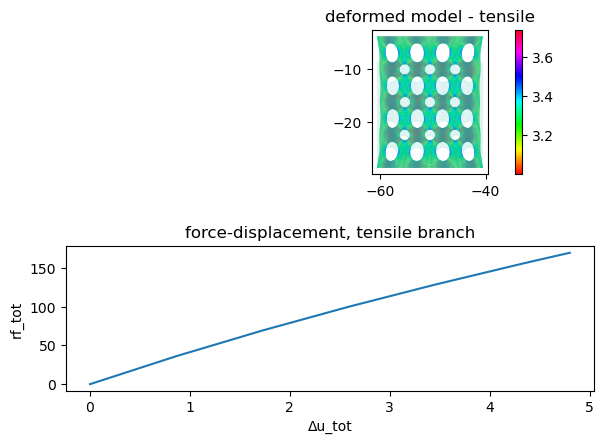

In [17]:
I1    = get_I1(elems, allus_t[end][1])

cfig  = figure()
ax1   = cfig.add_subplot(2,1,1)

plot_model(elems, nodes, alpha=0.05, 
  facecolor=:c, edgecolor=:c, cfig=cfig, ax=ax1)
plot_model(elems, nodes, u = allus_t[end][1], 
  edgecolor=:c, Φ = get_I1(elems, allus_t[end][1]), cfig=cfig, ax=ax1)
title("deformed model - tensile")

ax2   = cfig.add_subplot(2,1,2)
ax2.plot(Δu_tot_t, rf_tot_t)
xlabel("Δu_tot")
ylabel("rf_tot")
title("force-displacement, tensile branch")

cfig.tight_layout(pad=2.0, w_pad=2.0, h_pad=2.0)
;

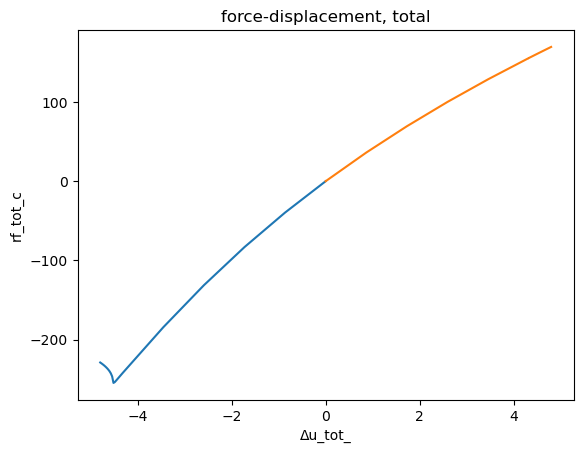

In [18]:
PyPlot.figure()
PyPlot.plot(Δu_tot_c, rf_tot_c, Δu_tot_t, rf_tot_t)
PyPlot.xlabel("Δu_tot_")
PyPlot.ylabel("rf_tot_c")
PyPlot.title("force-displacement, total")
;